In [1]:
%matplotlib inline

from kmedoids import fasterpam
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from persim import plot_diagrams
from ripser import ripser
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from tqdm import tqdm

# from atlas_covariant import *
from atlas_general import *
from grass_utils import *
from manifold_utils import quad_covector_to_covector_and_inner, \
                            quad_fit_full, \
                            matrix_to_quad_vector_matrix
# from minimum_volume_ellipsoid import MinimumVolumeEllipsoid
from mvee import mvee

In [2]:
n_pts = 1000
D = 3

def get_spherical_points(n, d):
        pts_pre = np.random.randn(n, d)
        norms = np.linalg.norm(pts_pre, axis=1)

        pts_list = []
        for pt_pre, norm in zip(pts_pre, norms):
                pts_list.append(pt_pre / norm)
        pts = np.vstack(pts_list)

        return pts

X = get_spherical_points(n_pts, D)
print(X.shape)

(1000, 3)


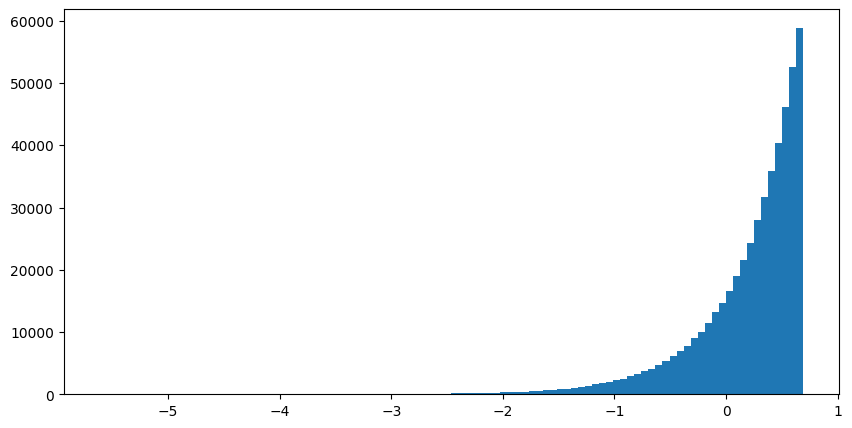

In [3]:
dist_mat_raw = euclidean_distances(X, X)

triu_inds = np.triu_indices(n_pts, 1)
dist_mat_flat = dist_mat_raw[triu_inds]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

# ax.hist(dist_mat_flat, bins=100)
ax.hist(np.log(dist_mat_flat), bins=100)

plt.show()

In [4]:
# Get "fine mesh", local distance graph
# delta = 0.1
# eps = 0.1
n_neigh = 10

G = nx.Graph()
for j in tqdm(range(n_pts)):
    X_j = X[j, :].reshape(1, 3)
    G.add_node(j)
    dist_vec = euclidean_distances(X_j, X)[0, :]
    inds_otra = list(range(n_pts))
    inds_otra.sort(key=lambda x: dist_vec[x])
    for k in inds_otra[1:(n_neigh+1)]:
        dist = dist_vec[k]
        G.add_edge(j, k, weight=dist)
    # for k in range(j+1, n_pts):
    #     dist = dist_vec[k]
    #     if dist <= eps:
    #         G.add_edge(j, k, weight=dist)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1910.10it/s]


In [5]:
dist_mat = np.zeros((n_pts, n_pts))

for j in tqdm(range(n_pts)):
    dist_dict, _ = nx.single_source_dijkstra(G, j, weight="weight")
    for k in range(j+1, n_pts):
        dist = dist_dict[k]
        dist_mat[j, k] = dist
        dist_mat[k, j] = dist

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.05it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 266.76it/s]


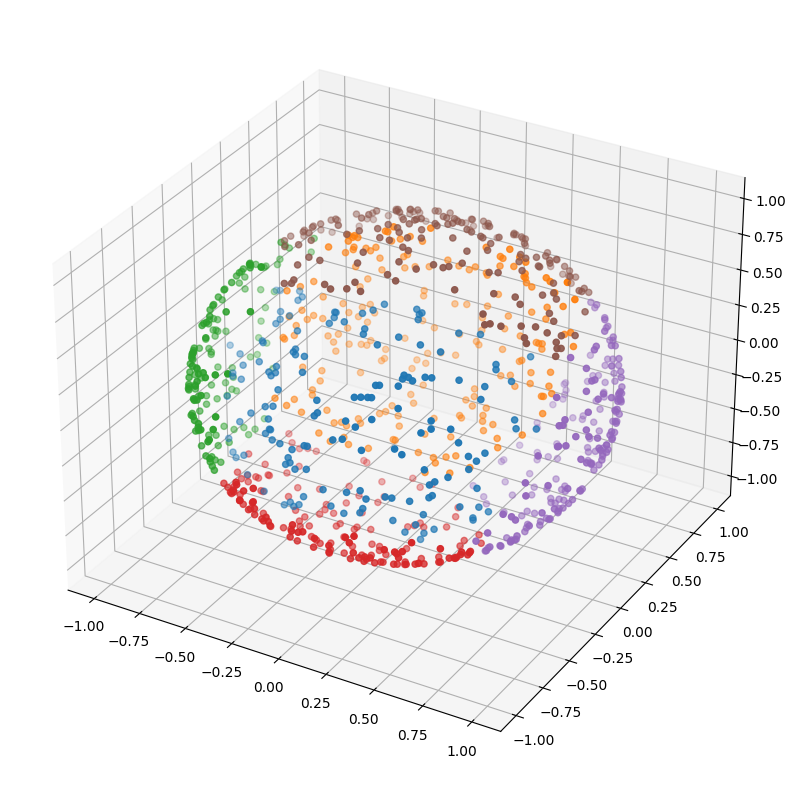

In [6]:
max_iter = int(1e8)
# k = 64
k = 6
pam_obj = fasterpam(dist_mat, k, max_iter=max_iter)

cmap_pre = plt.cm.tab10
n_colors = cmap_pre.N
# extract all colors from the .jet map
cmaplist = [cmap_pre(i) for i in range(cmap_pre.N)]
shaplist = ["o", "^", "s", "*"]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

for label in tqdm(range(k)):
    color = cmaplist[label % n_colors]
    shape = shaplist[label // n_colors]
    
    inds_oi = [ind for ind, val in enumerate(pam_obj.labels) \
                                      if (val == label)]

    X_oi = X[inds_oi, :]

    ax.scatter(X_oi[:, 0], X_oi[:, 1], X_oi[:, 2],
               color=color, marker=shape)

fig.savefig("mosaic_naive.png", dpi=300)

plt.show()

In [7]:
Y = matrix_to_quad_vector_matrix(X)

L_list = []
M_list = []
h_mat_list = []
x_0_list = []
X_par_list = []
t_mat_list = []

A_list = []
b_list = []
c_list = []

for label in tqdm(range(k)):
# for label in tqdm(range(k)):
    inds_oi = [ind for ind, val in enumerate(pam_obj.labels) \
                                      if (val == label)]
    labels_binary = [(val == label) for val in pam_obj.labels]
    svc_weights = [(np.inf if val else 1.0) for val in labels_binary]

    X_oi = X[inds_oi, :]
    Y_oi = Y[inds_oi, :]
    
    inds_no = [ind for ind in range(n_pts) if (ind not in inds_oi)]
    Y_no = Y[inds_no, :]
    
    # svc = SVC(kernel="linear")
    # svc.fit(Y, labels_binary, sample_weight=svc_weights)
    # c_list.append(svc.coef0)
    # b, A = quad_covector_to_covector_and_inner(svc.coef_.reshape(-1), 9)
    # b_list.append(b)
    # A_list.append(A)

    A, b, c = mvee(X_oi)
    A_list.append(A)
    b_list.append(b)
    c_list.append(c)
    
    # Create local quadratic approximation
    quad_params = quad_fit_full(X_oi, 2)
    L = quad_params["L"]
    M = quad_params["M"]
    h_mat = quad_params["h_mat"]
    x_0 = quad_params["mean"]

    L_list.append(L)
    M_list.append(M)
    h_mat_list.append(h_mat)
    x_0_list.append(x_0)

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


In [8]:
np.linalg.eigh(A)

print(A.shape)
print(b.shape)

(3, 3)
(3,)


In [9]:
atlas_gen = atlas_general(2, 3)

for x_0, L, M, h_mat, A, b, c in zip(x_0_list, 
                                    L_list, M_list,
                                    h_mat_list,
                                    A_list, b_list,
                                    c_list):
    atlas_gen.add_new_chart(x_0, L, M, h_mat, A, b, c)

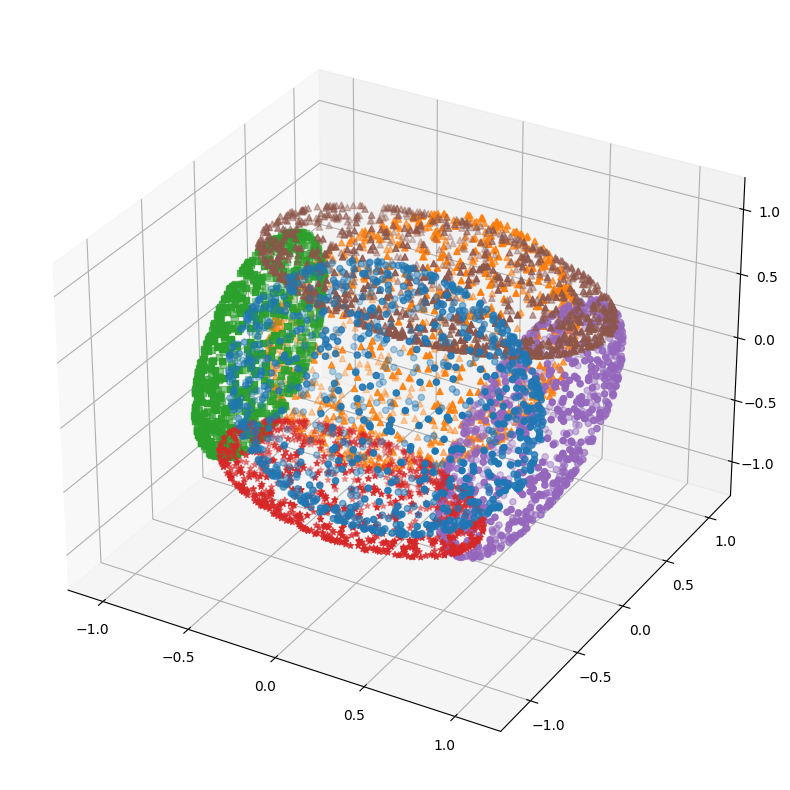

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
for kk in range(k):
    Y = get_spherical_points(n_pts, D)
    _, _, _, _, A, b, c = atlas_gen.chart_dict[kk]
    w, V = np.linalg.eigh(A)
    Q = V @ np.diag(w**(-1/2)) @ V.T
    Y = Y @ Q
    # Y += np.linalg.inv(Q) @ b / 2
    Qinv = np.linalg.inv(Q)
    # Y -= Qinv @ Qinv @ b / 2
    Y -= Q @ Q @ b / 2
    # Y -= Q @ b / 2

    ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2],
              color=cmaplist[kk], marker=shaplist[kk % 4])

plt.show()

In [11]:
atlas_gen.save_atlas("random_atlas")